# Visualizing the Hydrogel-Cell Interaction Solution

In this notebook, we visualize the hydrogel-cell interaction solution from the optimization algorithm. First we load the necessary libraries in the first input cell, then in the second cell there is the settings of the simulation.

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os.path
from itertools import permutations

module_path = '../module/'
sys.path.append(module_path)
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord

import pyshtools
from SHUtil import SHCilmToVector, SHVectorToCilm, lmk2K, K2lmk
from SHUtil import plotfv, TransMat, l_coeffs, m_coeffs, LM_list
from ShElastic import calSmode, calUmode
from SHBV import generate_submat, visualize_Cmat, print_SH_mode

from scipy.sparse.linalg import lsqr, spsolve
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize

from Case05_utilities import d2v, d2e, d2f
from Case05_utilities import Uvec2Tvec, Tvec2Uvec
from Case05_utilities import SHVec2mesh, visSHVec, visSH3d
from Case05_utilities import SHvec_rtoc, SHvec_ctor
from Case05_utilities import generate_fcache, generate_Xneigh, generate_Eneigh, generate_Fneigh

## The following cell is the setting of the simulation

`shapename` is the number of the shape.
`smoothed` indicates whether the shape is smoothed or not.
`dilated` indicates the traction-free mask, `_smoothed` for smoothing of the edge, `_1um_dilated` for dilation of the edge.

In [2]:
############################# change inputs here #################################
# Data file name
datadir = ''# '../testdata'
smoothed = '' #'smoothed' #lmax20_lwork15'
dilated = '' #'_softedge' # dilated = '_1um_dilated'; # dilated = '';
shapename = 'noise' # 'Shape2'
datafile = os.path.join(datadir, shapename+'_Coordinates_Cart_'+smoothed+'.csv')
connfile = os.path.join(datadir, shapename+'_Connectivity.csv')
maskfile = os.path.join(datadir, shapename+'_Mask'+dilated+'.csv')

# Material properties
mu0 = 300/3; nu0 = 0.499;
# Spherical Harmonics Analysis Settings
lJmax = 5; lKmax = lJmax; lmax_plot = 60;

# initial guess settings
# AKinitfile = 'AK_iter_'+shapename+('_lmax%d'%20)+'_1um_dilated.npy'
# ldamp_lo = int(lJmax/4); ldamp_hi = lJmax;

lwork = 15

# regularizations
myalpha = 1 #e-2  # traction magnitude
mybeta  = 1 #e-3  # coefficient magnitude

# program switches
plot_figure = True
node_face_dist_on = None
opt_proc = [2, ]; myord = 1; # 2: sol2dr; myord: p-norm order
#opt_proc = [0, 1, 0, 1, 0, 1, 0, 1, 0]  # 1: node-face on; 0: node-face off;

# minimization settings
N_period = 2
maxiter_per_period = 1
CG_gtol = 1e-4
minimizer = 'CG'
minimizer_config = {'maxiter': maxiter_per_period, 'gtol': CG_gtol, 'disp': True}
# method='Powell', options={'maxiter':1, 'maxfev':10, 'disp': True})

# dump files for minimization
savefig = False
savename = shapename # +('_a%.0e_b%.0e'%(myalpha, mybeta))+('_lmax%d'%lJmax)+smoothed+dilated
folder = '' #'Case06-Noise-true'
AKfile = os.path.join(folder, 'AK_iter_'+savename+'.npy')
fvfile = os.path.join(folder, 'fv_'+savename+'.txt')

AKinit = np.load(AKfile)
lJmax = np.sqrt(AKinit.size/3).astype(int) - 1; lKmax = lJmax;
print(lJmax, lKmax)

# settings for loading \hat{U}, \hat{T} coefficients
shtype = 'reg'
coeff_dir = os.path.join(module_path, 'lmax%dmodes'%60)

# neibor list settings
# n_list = 200
# n_load = 10
# n_recal_neigh = 1
# file_neigh = shapename + '_neigh%d_lmax%d'%(n_list, lJmax) + smoothed + dilated

#################################################################################
mu = 1.; nu = nu0;
Umodes = loadmat(os.path.join(coeff_dir,'Umodes.mat'))
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullDmat = calUmode(Umodes, mu, nu)
Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax, kJ=3).tocsc()

Tmodes = loadmat(os.path.join(coeff_dir,'Tmodes.mat'))
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax, kJ=3).tocsc()

10 10


data: (7381, 3)


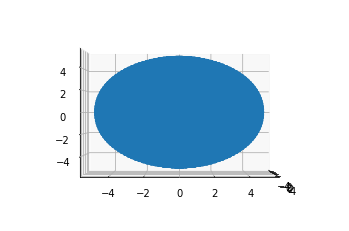

In [3]:
#### load the geometry ####
# Vs, Vp: list of nodes (nV, trivial), coordinates of the nodes (nVx3)
# Es, Ep: list of edges (nEx2), list of points on the edges (nEx2x3)
# Fs, Fp: list of facets (nFx3), list of points on the facets (nFx3x3)
# Tfv: traction free boundary map of the node list
# Tfe: traction free boundary map of the edge list
# Tff: traction free boundary map of the face list
# Tf_diluted: diluted traction free boundary map

data = np.genfromtxt(datafile, delimiter=',')
if dilated == '_softedge':
    masktype = np.float
else:
    masktype = np.int
mask = np.genfromtxt(maskfile, dtype=masktype)
print('data:', data.shape)

Np = data.shape[0]
Vp = data[..., :3]

if dilated == '_softedge':
    Tfv = (mask > 0.5)
else:
    Tfv = mask.astype(np.bool)

#### Plot the geometry (Vp) ####
fig = plt.figure()#figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2])
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2])

ax.view_init(azim=0, elev=0)

#ax.set_aspect('equal')
plt.show()

The original radius of the particle $r_0=5\mu m$ in this test case:

In [4]:
r0 = 5
vol = 4/3*np.pi*r0**3

print('V = %.4f, r0 = %.4f'%(vol, r0))

V = 523.5988, r0 = 5.0000


The next cell shows the convergence behavior of the optimization. The first subplot includes the curve for all three parts of the target function: average shape-difference $\Delta x$, average traction magnitude $\alpha\|T\|$ and the regularization term $\beta\|U_KT_K\|$, or $\beta E_{el}$.

In [5]:
import glob
n_steps = len(glob.glob('AK_final_??.npz'))
for i in range(n_steps):
    AKiter_filename = 'AK_final_%02d.npz'%i
    Nsteps    = np.load(AKiter_filename)['N']
    new_funvals = np.load(AKiter_filename)['fv_iter'][-Nsteps:, :]
    load_alpha = np.load(AKiter_filename)['alpha']
    load_beta = np.load(AKiter_filename)['beta']
    #new_funvals[:, 4] *= load_alpha
    #new_funvals[:, 5] *= load_beta
    alpha_beta = np.ones([Nsteps, 2]) * np.array([load_alpha, load_beta])[None, :]
    #print(new_funvals.shape, alpha_beta.shape)
    new_funvals = np.hstack([new_funvals, alpha_beta])
    
    if i == 0:
        funvals = new_funvals
    else:
        funvals = np.vstack([funvals, new_funvals])

plot_funval = funvals
print(plot_funval.shape)

(40, 9)


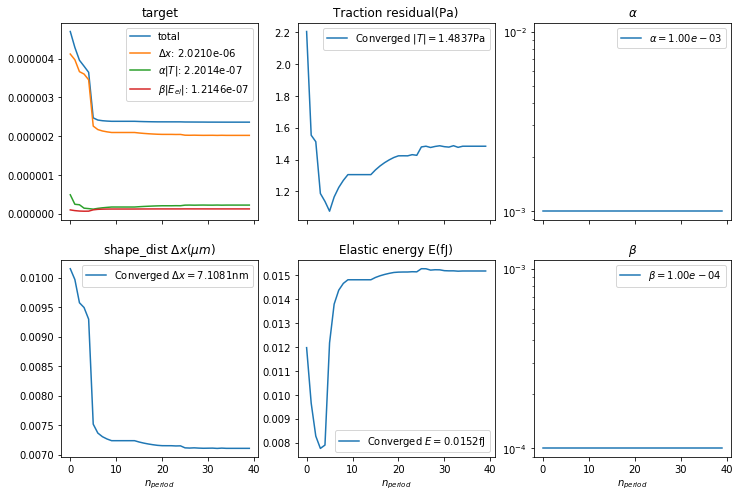

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True)
axs[0, 0].plot(plot_funval[:, 0], label=r'total')
axs[0, 0].plot(plot_funval[:, 3], label=r'$\Delta x$: %.4e'%plot_funval[-1, 3])
axs[0, 0].plot(plot_funval[:, 4]*plot_funval[:, 7], label=r'$\alpha\|T\|$: %.4e'%(plot_funval[-1, 4]*plot_funval[-1, 7]))
axs[0, 0].plot(plot_funval[:, 5]*plot_funval[:, 8], label=r'$\beta\|E_{el}\|$: %.4e'%(plot_funval[-1, 5]*plot_funval[-1, 8]))
axs[0, 0].legend()
axs[0, 0].set_title('target')
#axs[0, 0].set_xlabel(r'$n_{period}$')
axs[1, 0].plot(plot_funval[:, 1], label='Converged $\Delta x = %.4f$nm'%(plot_funval[-1, 1]*1e3))
axs[1, 0].set_title('shape_dist $\Delta x(\mu m)$')
axs[1, 0].set_xlabel(r'$n_{period}$')
axs[1, 0].legend()
axs[0, 1].plot(plot_funval[:, 2], label='Converged $\|T\| = %.4f$Pa'%(plot_funval[-1, 2]))
axs[0, 1].set_title('Traction residual(Pa)')
#axs[0, 1].set_xlabel(r'$n_{period}$')
axs[0, 1].legend()
Eel = plot_funval[:, 5]*(r0/1e6)**3*mu0*1e15
axs[1, 1].plot(Eel, label='Converged $E = %.4f$fJ'%(Eel[-1]))
axs[1, 1].set_title('Elastic energy E(fJ)')
axs[1, 1].set_xlabel(r'$n_{period}$')
axs[1, 1].legend()
axs[0, 2].semilogy(plot_funval[:, 7], label=r'$\alpha=%.2e$'%(plot_funval[-1, 7]))
axs[0, 2].set_title(r'$\alpha$')
#axs[0, 2].set_xlabel(r'$n_{period}$')
axs[0, 2].legend()
axs[1, 2].semilogy(plot_funval[:, 8], label=r'$\beta=%.2e$'%(plot_funval[-1, 8]))
axs[1, 2].set_title(r'$\beta$')
axs[1, 2].set_xlabel(r'$n_{period}$')
axs[1, 2].legend()
if savefig:
    fig.savefig(savename+'_convergence.png', transparent=True)
plt.show()

In the next cell, we plot the spherical harmonic coefficients of displacement $\hat{U}_K$, traction $\hat{T}_K$, and the coefficients in the solution space $a_K$.

Plot the Solution Coefficients


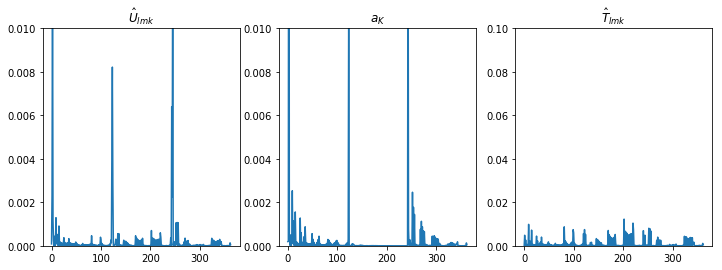

In [7]:
# Load the solution file
AK_sol = np.load(AKfile)
Uvec1 = Dmat.dot(AK_sol); Tvec1 = Cmat.dot(AK_sol)

print('Plot the Solution Coefficients')
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(np.abs(Uvec1)); plt.ylim(0, 0.01); plt.title('$\hat{U}_{lmk}$')
plt.subplot(132)
plt.plot(np.abs(AK_sol)); plt.ylim(0, 0.01); plt.title('$a_K$')
plt.subplot(133)
plt.plot(np.abs(Tvec1)); plt.ylim(0, 0.1); plt.title('$\hat{T}_{lmk}$')
if savefig:
    plt.savefig(savename+'_coeffs.png', transparent=True)
plt.show()

Plot the Solution Coefficients


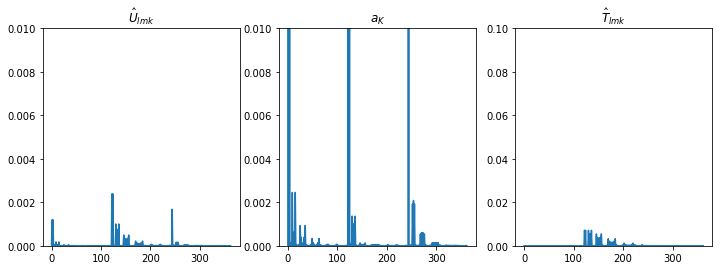

In [8]:
# Load the true solution
AK_true = np.load('AK_true.npy')
Uvec_true = Dmat.dot(AK_true); Tvec_true = Cmat.dot(AK_true)

print('Plot the Solution Coefficients')
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(np.abs(Uvec_true)); plt.ylim(0, 0.01); plt.title('$\hat{U}_{lmk}$')
plt.subplot(132)
plt.plot(np.abs(AK_true)); plt.ylim(0, 0.01); plt.title('$a_K$')
plt.subplot(133)
plt.plot(np.abs(Tvec_true)); plt.ylim(0, 0.1); plt.title('$\hat{T}_{lmk}$')
if savefig:
    plt.savefig(savename+'_coeffs.png', transparent=True)
plt.show()

In the next cell, we plot the displacement map and traction map correspond to the solution.

Plot displacement map


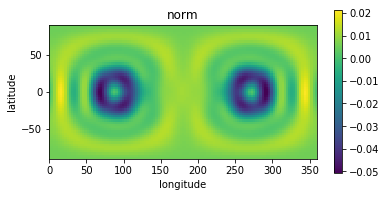

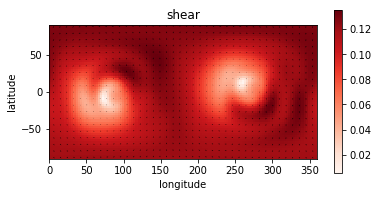

Plot traction map


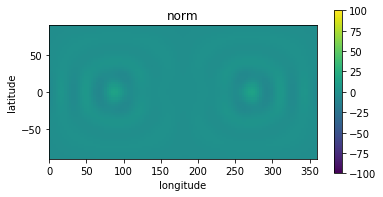

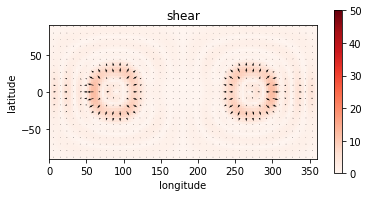

In [9]:
print('Plot displacement map')
fig, ax = visSHVec(Uvec1*r0, lmax_plot=lmax_plot,
                   SphCoord=True, Complex=True,     # spherical coord switch, complex coefficient switch
                   # n_vrange=(-1,1), s_vrange=(0,0.01), # normal and shear map value range
                   config_quiver=(2, 3, 'k', 20),   # setting of quiver in shear map
                   lonshift=180,                    # shift the map in longitude direction
                   figsize=(6,3), show=False)       # figure size
if savefig:
    fig[0].savefig(savename+'_un.png', transparent=False)
    fig[1].savefig(savename+'_us.png', transparent=False)
plt.show()

print('Plot traction map')
fig, ax = visSHVec(Tvec1*mu0, lmax_plot=lmax_plot, 
                   SphCoord=True, Complex=True,     # spherical coord switch, complex coefficient switch
                   n_vrange=(-100, 100), s_vrange=(0, 50), # normal and shear map value range
                   config_quiver=(2, 3, 'k', 500), # setting of quiver in shear map
                   lonshift=180,                    # shift the map in longitude direction
                   figsize=(6,3), show=False)       # figure size
if savefig:
    fig[0].savefig(savename+'_Tn.png', transparent=False)
    fig[1].savefig(savename+'_Ts.png', transparent=False)
plt.show()

In the next cell, we plot the residual displacement map and residual traction map correspond to the true solution.

Plot displacement map


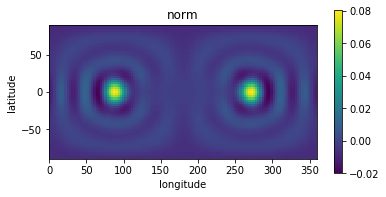

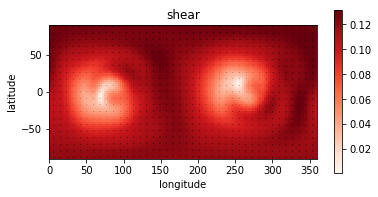

Plot traction map


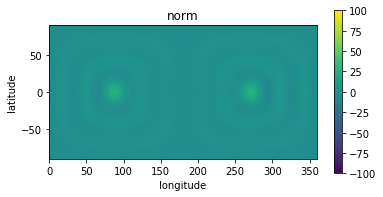

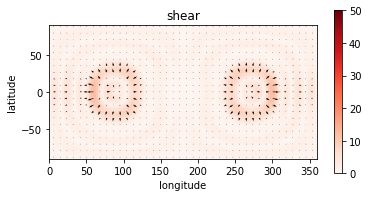

In [10]:
print('Plot displacement map')
fig, ax = visSHVec((Uvec1-Uvec_true)*r0, lmax_plot=lmax_plot,
                   SphCoord=True, Complex=True,     # spherical coord switch, complex coefficient switch
                   # n_vrange=(-1,1), s_vrange=(0,0.01), # normal and shear map value range
                   config_quiver=(2, 3, 'k', 20),   # setting of quiver in shear map
                   lonshift=180,                    # shift the map in longitude direction
                   figsize=(6,3), show=False)       # figure size
if savefig:
    fig[0].savefig(savename+'_un.png', transparent=False)
    fig[1].savefig(savename+'_us.png', transparent=False)
plt.show()

print('Plot traction map')
fig, ax = visSHVec((Tvec1-Tvec_true)*mu0, lmax_plot=lmax_plot, 
                   SphCoord=True, Complex=True,     # spherical coord switch, complex coefficient switch
                   n_vrange=(-100, 100), s_vrange=(0, 50), # normal and shear map value range
                   config_quiver=(2, 3, 'k', 500), # setting of quiver in shear map
                   lonshift=180,                    # shift the map in longitude direction
                   figsize=(6,3), show=False)       # figure size
if savefig:
    fig[0].savefig(savename+'_Tn.png', transparent=False)
    fig[1].savefig(savename+'_Ts.png', transparent=False)
plt.show()

In the next cell, we compare the shape using the radial displacement $u_r$. The fitted shape has radial displacement of $u_t$, and the difference between the data and the fitted shape is also given.

In [11]:
# Vp -> ur (radial displacement) -> u1 (x,y,z)
Vr, Vthe, Vphi = CartCoord_to_SphCoord(Vp[...,0], Vp[...,1], Vp[...,2])
Vphi[Vphi < 0] += 2*np.pi
Vlat = 90-np.rad2deg(Vthe)
Vlon = np.rad2deg(Vphi)
ur = (Vr - r0)/r0

urcilm_interp, chi2ur = pyshtools.expand.SHExpandLSQ(ur, Vlat, Vlon, lmax=lJmax)
ucoeff_interp = pyshtools.SHCoeffs.from_array(urcilm_interp)
urgrid_interp = ucoeff_interp.expand('GLQ')

latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lmax_plot)
lon = np.deg2rad(lonsdeg)
colat = np.deg2rad(90-latsdeg)
PHI, THETA = np.meshgrid(lon, colat)
R = np.ones_like(PHI)
X,Y,Z = SphCoord_to_CartCoord(R, THETA, PHI)
X0 = np.stack([X,Y,Z], axis=-1)
Xt = X0 + SHVec2mesh(Uvec1, lmax=lmax_plot, SphCoord=False, Complex=True)

rt, thet, phit = CartCoord_to_SphCoord(Xt[...,0], Xt[...,1], Xt[...,2])
phit[phit < 0] += 2*np.pi
latt = 90-np.rad2deg(thet)
lont = np.rad2deg(phit)
urt = rt - 1

rtcilm_interp, chi2ut = pyshtools.expand.SHExpandLSQ(urt.flatten(), latt.flatten(), lont.flatten(), lmax=lJmax)
print('Residuals for expanding into spherical harmonics. ur: %.4f ut: %.4f'%(chi2ur, chi2ut))

Residuals for expanding into spherical harmonics. ur: 0.0000 ut: 0.0010


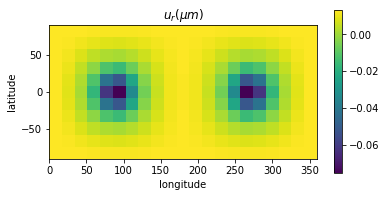

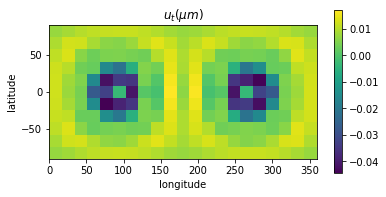

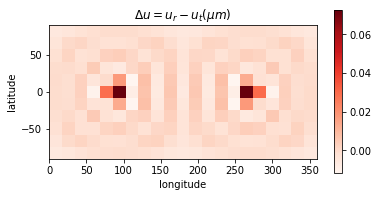

Average squared distance on unit sphere: 2.6833887302206063e-06
Averaged shape difference 0.00819053(um)


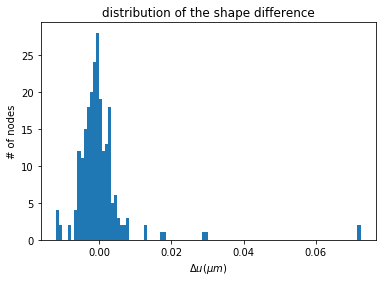

In [12]:
utcoeff_interp = pyshtools.SHCoeffs.from_array(rtcilm_interp)
utgrid_interp = utcoeff_interp.expand('GLQ')
fig, ax = plotfv(urgrid_interp.to_array()*r0, lonshift=180, show=False, figsize=(6,3))
ax.set_title('$u_r (\mu m)$')
if savefig:
    fig.savefig(savename+'_ur.png', transparent=True)
fig, ax = plotfv(utgrid_interp.to_array()*r0, lonshift=180, show=False, figsize=(6,3))
ax.set_title('$u_t (\mu m)$')
if savefig:
    fig.savefig(savename+'_ut.png', transparent=True)

udgrid_interp = urgrid_interp.copy()
TT = np.deg2rad(90 - udgrid_interp.lats())
PP = np.deg2rad(udgrid_interp.lons())
ud_tmp = utgrid_interp.to_array() - urgrid_interp.to_array()
udz_tmp = ud_tmp * np.cos(TT[:,np.newaxis])
ud_new = np.sqrt(ud_tmp**2 - udz_tmp**2 + (udz_tmp)**2)
udgrid_interp.data = np.sign(ud_tmp) * ud_new #* np.sin(TT[:,np.newaxis])
fig, ax = plotfv(udgrid_interp.to_array()*r0, lonshift=180, show=False, cmap='Reds', figsize=(6,3))
ax.set_title('$\Delta u = u_r-u_t (\mu m)$')
if savefig:
    fig.savefig(savename+'_ud.png', transparent=True)
plt.show()

dist_ud = np.mean((udgrid_interp.data**2)*np.sin(TT[:,np.newaxis]))
print('Average squared distance on unit sphere:', dist_ud)
print('Averaged shape difference %.8f(um)'%(np.sqrt(dist_ud)*r0))
plt.hist(udgrid_interp.data.flatten()*r0, bins=100)
plt.title('distribution of the shape difference')
plt.ylabel('# of nodes'); plt.xlabel('$\Delta u(\mu m)$');
if savefig:
    plt.savefig(savename+'_dhist.png', transparent=True)
plt.show()

In [13]:
print('Evaluate Displacement and Traction in Cartesian Coordinates for plotting 3d shape...')
umesh1 = SHVec2mesh(Uvec1, lmax=lJmax, SphCoord=False, Complex=True)
tmesh1 = SHVec2mesh(Tvec1*mu0, lmax=lJmax, SphCoord=False, Complex=True)
umesh1_fine = SHVec2mesh(Uvec1, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh1_fine = SHVec2mesh(Tvec1*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)

Evaluate Displacement and Traction in Cartesian Coordinates for plotting 3d shape...


Visualize the nodes in 3D...


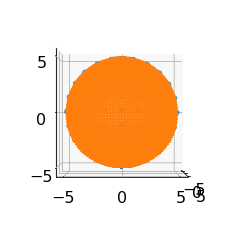

In [14]:
print('Visualize the nodes in 3D...')
fig, ax = visSH3d(umesh1, cmesh=tmesh1, r0=r0, show=False, elevation=0, azimuth=0, surface=False, figsize=(4,4))
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
if savefig:
    plt.tight_layout(); plt.savefig(savename+'_compare.png', transparent=True)
plt.show()

Visualize the shape in 3D...


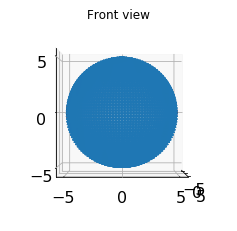

In [15]:
print('Visualize the shape in 3D...')
fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, 
                  r0=r0, show=False, 
                  elevation=0, azimuth=0, 
                  surface=True, figsize=(4,4))

# reference data
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
ax.set_title('Front view')
if savefig:
    plt.tight_layout(); plt.savefig(savename+'_front.png', transparent=True)
plt.show()

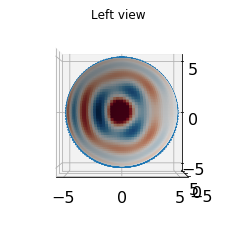

In [16]:
fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, 
                  r0=r0, show=False, 
                  elevation=0, azimuth=-90, 
                  surface=True, figsize=(4,4))

# Plot reference data
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
ax.set_title('Left view')
if savefig:
    plt.tight_layout(); plt.savefig(savename+'_left.png', transparent=True)
plt.show()

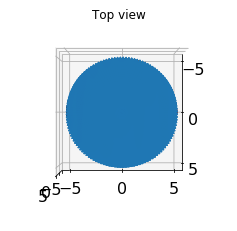

In [17]:
fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, 
                  r0=r0, show=False, 
                  elevation=90, azimuth=0, 
                  surface=True, figsize=(4,4))

# Plot reference data
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
ax.set_title('Top view')
if savefig:
    plt.tight_layout(); plt.savefig(savename+'_top.png', transparent=True)
plt.show()

In [18]:
latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lmax_plot)
lons, lats = np.meshgrid(lonsdeg, latsdeg)

umesh_Cart = SHVec2mesh(Uvec1*r0, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh_Cart = SHVec2mesh(Tvec1*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)
umesh_Sph = SHVec2mesh(Uvec1*r0, lmax=lmax_plot, SphCoord=True, Complex=True)
tmesh_Sph = SHVec2mesh(Tvec1*mu0, lmax=lmax_plot, SphCoord=True, Complex=True)
savemat(os.path.join(folder, savename+'.mat'),
        {'umesh_Cart':umesh_Cart, 'tmesh_Cart':tmesh_Cart,
         'umesh_Sph': umesh_Sph,  'tmesh_Sph': tmesh_Sph,
         'lats': lats, 'lons': lons, 'r0': r0,  'mu0': mu0})
#          'ugrid_Cart':ugrid_Cart, 'tmesh_Cart':tgrid_Cart,
#          'ugrid_Sph': ugrid_Sph,  'tmesh_Sph': tgrid_Sph,
#          'lat': Vlat, 'lon': Vlon, 
# ugrid_Cart = SHVec2mesh(Uvec1*r0, lat=Vlat, lon=Vlon, lmax=lmax_plot, SphCoord=False, Complex=True)
# tgrid_Cart = SHVec2mesh(Tvec1*mu0, lat=Vlat, lon=Vlon, lmax=lmax_plot, SphCoord=False, Complex=True)
# ugrid_Sph = SHVec2mesh(Uvec1*r0, lat=Vlat, lon=Vlon, lmax=lmax_plot, SphCoord=True, Complex=True)
# tgrid_Sph = SHVec2mesh(Tvec1*mu0, lat=Vlat, lon=Vlon, lmax=lmax_plot, SphCoord=True, Complex=True)